In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification

from sklearn.neighbors import KNeighborsClassifier

#creating dataframe from raw data .csv file. Note there are 2609 observations and 231 columns (variables)
df_unfiltered = pd.read_csv('Final_Report_of_the_Asian_American_Quality_of_Life__AAQoL_.csv')

In [3]:
#Filtering for only non-student survey takers. Note, no one in the sample marked unemployed. 
#There were homemakers (housewives) but those observations are not included because they are not earning any personal income.
#Retired not included because we do not know where income is coming from. Likely social security / retirement savings.

df_filtered = df_unfiltered[
    (df_unfiltered['Full Time Employment'] == 'Employed full time') |
    (df_unfiltered['Part Time Employment'] == 'Employed part time')]

#Creating an 'Income_binary' column conditional on 'Income'. Individials are classified as either "Above $60,000" or "Below $60,000".
#Note, median income in Texas ~$64,000 at time of survey (2015).
df_filtered['Income_binary'] = df_filtered['Income'].apply(lambda x: "Above $60,000" if (x == "$70,000 and over" or x== "$60,000 - $69,999")  else "Below $60,000")


# Create a dictionary to map categories to numerical values
mapping = {"Not at all": 1, "Not well": 2, "Well": 3, "Very well": 4}
# Use the map function to create a new column with numerical values
df_filtered['Numerical English Speaking'] = df_filtered['English Speaking'].map(mapping)


# Use get_dummies to create dummy variables for the "Religion" column
dummy_columns = pd.get_dummies(df_filtered['Religion'], prefix='Religion')
# Add a suffix to the dummy columns
dummy_columns.columns = dummy_columns.columns + '_dummy'
# Join the dummy columns to the original DataFrame
df_filtered = pd.concat([df_filtered, dummy_columns], axis=1)

# Use get_dummies to create dummy variables for the "Ethnicity" column
dummy_columns = pd.get_dummies(df_filtered['Ethnicity'], prefix='Ethnicity')
# Add a suffix to the dummy columns
dummy_columns.columns = dummy_columns.columns + '_dummy'
# Join the dummy columns to the original DataFrame
df_filtered = pd.concat([df_filtered, dummy_columns], axis=1)

# Create a (1,0) binary version of the 'Gender' variable. Coded as 1 for male 0 for female
df_filtered['Male'] = df_filtered['Gender'].apply(lambda x: 1 if x=="Male" else 0)

# Create a (1,0) binary version of the 'Marital Status' variable. Coded as 1 for married 0 otherwise
df_filtered['Married'] = df_filtered['Marital Status'].apply(lambda x: 1 if x=="Married" else 0)

#Creating an 'Experience' column that is age minus education completed minus 6
df_filtered['Experience'] = df_filtered['Age']-df_filtered['Education Completed']-6

#Collecting columns of interest to drop Na's
columns_to_drop_na = ["Education Completed", "Religion_None_dummy", "Religion_Other_dummy", 
                      "Religion_Protestant_dummy", "Religion_Buddhist_dummy", "Religion_Catholic_dummy", 
                      "Religion_Hindu_dummy", "Religion_Muslim_dummy", "Ethnicity_Chinese_dummy", 
                      "Ethnicity_Asian Indian_dummy", "Ethnicity_Korean_dummy", "Ethnicity_Vietnamese_dummy", 
                      "Ethnicity_Filipino_dummy", "Ethnicity_Other_dummy", "Numerical English Speaking", 
                      "Income_binary", "Male", "Experience","Married"]



# Drop rows with Na values in the specified columns
df_filtered = df_filtered.dropna(subset=columns_to_drop_na)


from sklearn.model_selection import train_test_split
#Constructing the feature and dependent vectors

#Feature variables: Eduacation Completed (numeric), Religion (dummies), Ethnicity (dummies), 
#   Numerical English Speaking (numeric), Male (dummy), Experience (numeric), Marital Status (string)
#Dummy comparison to Protestant and Chinese (meaning they are left out).
X = df_filtered[["Education Completed","Religion_None_dummy", "Religion_Other_dummy",
                 "Religion_Buddhist_dummy","Religion_Catholic_dummy","Religion_Hindu_dummy",
                 "Religion_Muslim_dummy","Ethnicity_Asian Indian_dummy","Ethnicity_Korean_dummy",
                 "Ethnicity_Vietnamese_dummy","Ethnicity_Filipino_dummy","Ethnicity_Other_dummy",
                 "Numerical English Speaking", "Male", "Experience", "Married"]]

#Specifying the dependent variable as 'Income_binary' (string)
Y = np.array(df_filtered["Income_binary"])

#Splitting data into training and test data sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0)

# Create a (1,0) binary version of the target variable
Y_train_binary = (Y_train == "Above $60,000").astype(int)

# Create a (1,0) binary version of the target variable
Y_test_binary = (Y_test == "Above $60,000").astype(int)

print(X_train)
print(Y_train)

      Education Completed  Religion_None_dummy  Religion_Other_dummy  \
2278                 17.0                    0                     0   
902                  17.0                    0                     0   
892                  16.0                    0                     0   
1242                 16.0                    0                     0   
2340                 16.0                    0                     1   
...                   ...                  ...                   ...   
1523                 17.0                    0                     0   
1688                 12.0                    0                     0   
2337                 17.0                    0                     0   
1066                 17.0                    0                     0   
1359                 17.0                    0                     0   

      Religion_Buddhist_dummy  Religion_Catholic_dummy  Religion_Hindu_dummy  \
2278                        0                        1 

/opt/jupyterhub/pyvenv/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


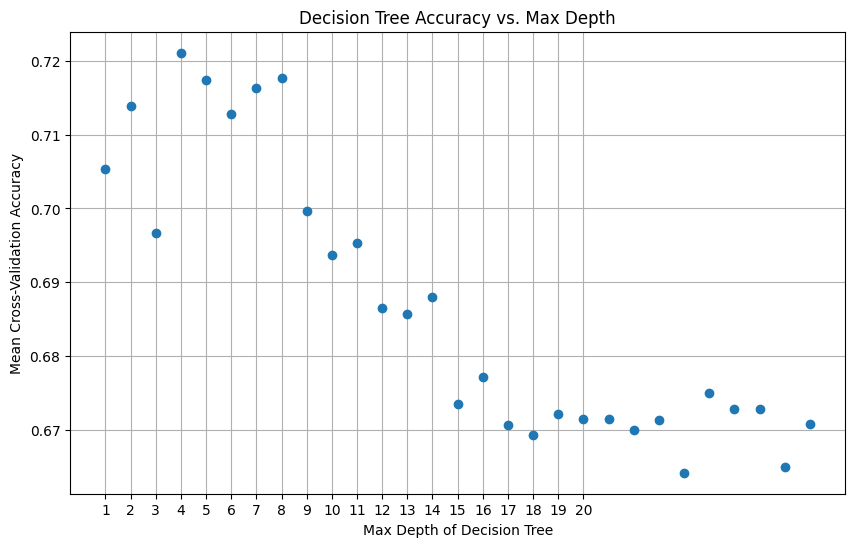

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

#Below is the process to determine which max_depth to use. Accuracy appears to level off after depth=8.

# Define the range of max_depth values to explore
max_depth_values = range(1, 30)

# Initialize empty lists to store mean and standard deviation of cross-validation scores
mean_cv_scores = []

for depth in max_depth_values:
    decision_tree = DecisionTreeClassifier(max_depth=depth)
    cv_scores = cross_val_score(decision_tree, X, Y, cv=50)
    mean_cv_scores.append(np.mean(cv_scores))

 # Plot the results 
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, mean_cv_scores, 'o')
plt.xlabel('Max Depth of Decision Tree')
plt.ylabel('Mean Cross-Validation Accuracy')
plt.title('Decision Tree Accuracy vs. Max Depth')
plt.grid(True)
plt.xticks(np.arange(1, 21, step=1))
plt.show()


/opt/jupyterhub/pyvenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.77      0.61      0.68       155
           1       0.73      0.85      0.79       193

    accuracy                           0.74       348
   macro avg       0.75      0.73      0.73       348
weighted avg       0.75      0.74      0.74       348

Education Summary Statistics
Mean: 15.434125269978402
Standard Deviation: 2.094117796695893
Maximum: 17.0
Minimum: 2.0

Intercept: -7.247554371280178
                         Feature  Coefficient  P-value
0            Education Completed     0.328074    0.000
1            Religion_None_dummy    -0.282949    0.000
2           Religion_Other_dummy    -0.049437    0.000
3        Religion_Buddhist_dummy    -0.443078    0.000
4        Religion_Catholic_dummy     0.160429    0.000
5           Religion_Hindu_dummy    -0.070412    0.000
6          Religion_Muslim_dummy    -0.755537    0.000
7   Ethnicity_Asian Indian_dummy    

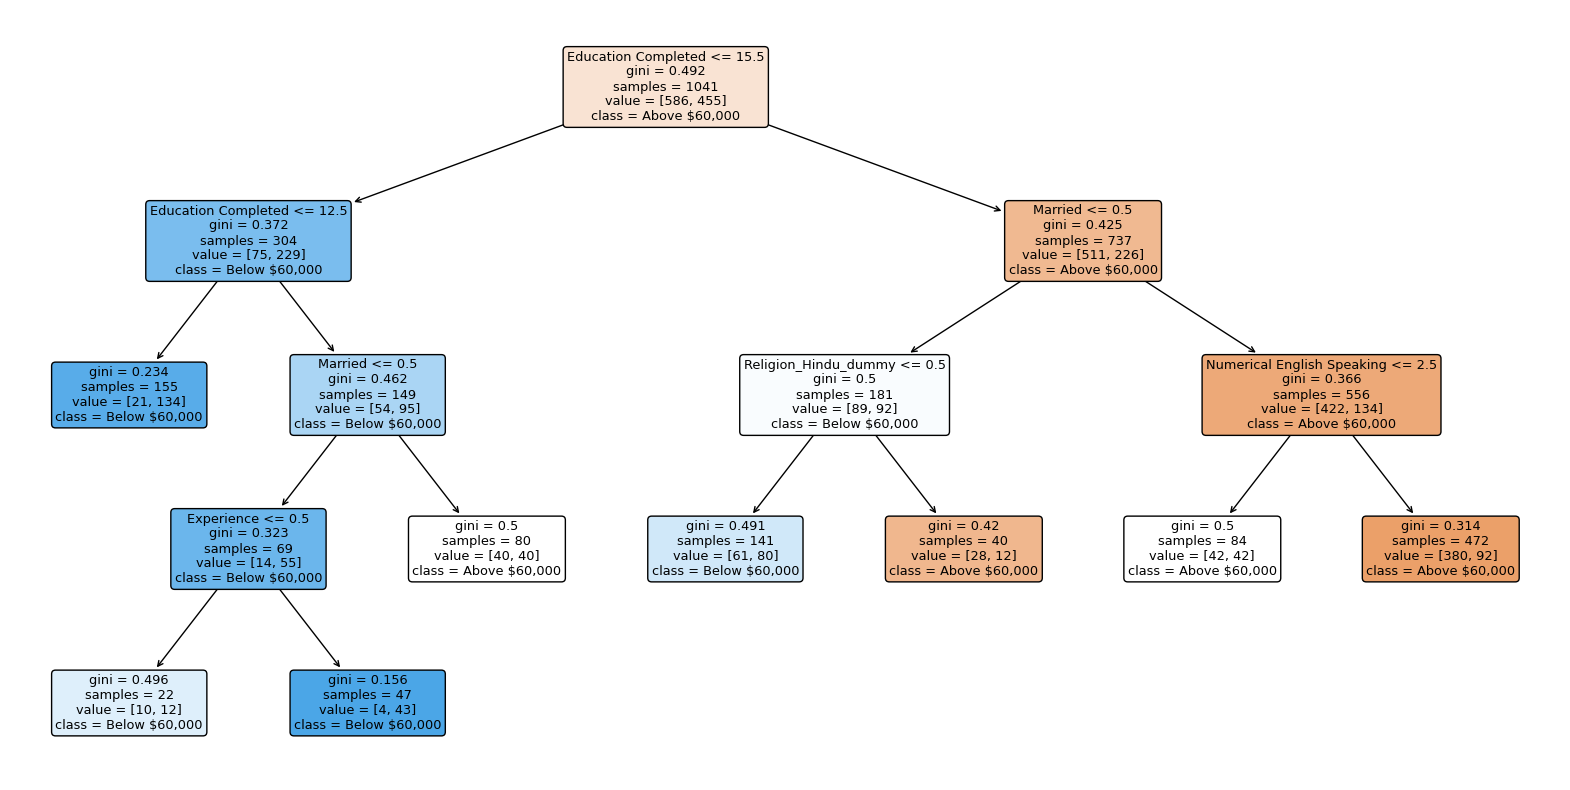

Classification Report for Decision Tree:
               precision    recall  f1-score   support

Above $60,000       0.71      0.84      0.77       193
Below $60,000       0.74      0.56      0.64       155

     accuracy                           0.72       348
    macro avg       0.72      0.70      0.70       348
 weighted avg       0.72      0.72      0.71       348



In [17]:
import numpy as np
from sklearn.linear_model import LogisticRegression

# Logistic Regression
logreg = LogisticRegression()
logreg_fit = logreg.fit(X_train, Y_train_binary)
Y_pred_logreg = logreg.predict(X_test)

from sklearn.metrics import classification_report

# Print classification report for Logistic Regression
print("Classification Report for Logistic Regression:")
print(classification_report(Y_test_binary, Y_pred_logreg))



#Education summary statistics
std_dev = np.std(df_filtered['Education Completed'])
mean_value = np.mean(df_filtered['Education Completed'])
max_value = np.max(df_filtered['Education Completed'])
min_value = np.min(df_filtered['Education Completed'])

print("Education Summary Statistics")
print("Mean:", mean_value)
print("Standard Deviation:", std_dev)
print("Maximum:", max_value)
print("Minimum:", min_value)
print("")


# Get the coefficients and intercept
coefficients = logreg_fit.coef_[0]  # Assuming binary classification, so take the first (and only) row
intercept = logreg_fit.intercept_[0]  # Assuming binary classification, so take the first (and only) intercept
print("Intercept:", intercept)

import scipy.stats as stats
# Calculate standard errors, t-values, and p-values
standard_errors = stats.sem(X_train, axis=0)
t_values = coefficients / standard_errors
p_values = 2 * (1 - stats.norm.cdf(abs(t_values)))

# Create a DataFrame for coefficients and p-values
result_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': coefficients,
    'P-value': p_values
})

# Round p-values to 3 decimal places
result_df['P-value'] = result_df['P-value'].round(3)

# Display results
print(result_df)


from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt


# Decision tree modeling
dt_model = DecisionTreeClassifier(max_leaf_nodes=8)
dt_fit = dt_model.fit(X_train, Y_train)
dt_predictions = dt_model.predict(X_test)

unique_classes = np.unique(Y_train)

# Visualize the decision tree
plt.figure(figsize=(20, 10))
plot_tree(dt_fit, feature_names=X_train.columns, class_names=unique_classes, filled=True, rounded=True)
plt.show()

# Calculate and print the classification report
classification_rep = classification_report(Y_test, dt_predictions)

print("Classification Report for Decision Tree:")
print(classification_rep)



/opt/jupyterhub/pyvenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[165  28]
 [ 61  94]]
[[163  30]
 [ 68  87]]


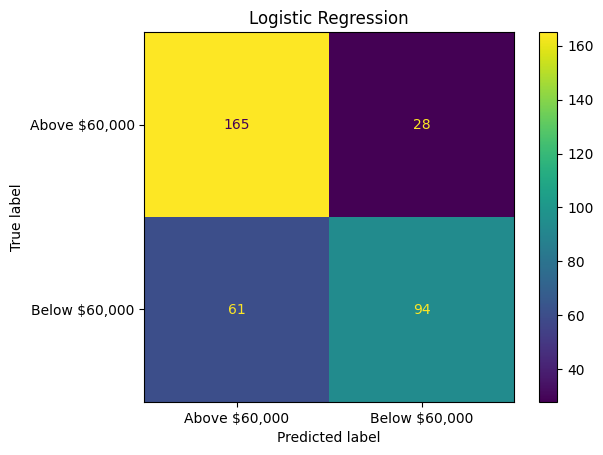

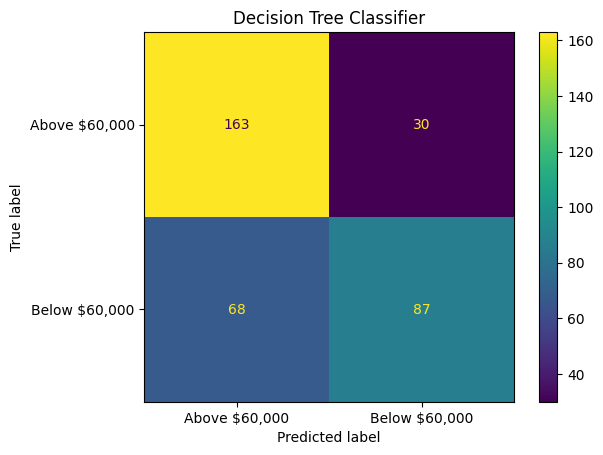

In [7]:
from sklearn.metrics import plot_confusion_matrix

#Creating a second logistic regression fit so labels are string not binary [0,1]
logreg_fit2 = logreg.fit(X_train, Y_train)

# plot the confusion matrix for the test sub-set
disp = plot_confusion_matrix(logreg_fit2, X_test, Y_test)
plt.title("Logistic Regression")

print(disp.confusion_matrix)

# plot the confusion matrix for the test sub-set
disp = plot_confusion_matrix(dt_fit, X_test, Y_test)
plt.title("Decision Tree Classifier")

print(disp.confusion_matrix)